In [1]:
from pandas_datareader import data
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles

%matplotlib inline

In [2]:
def calc_sigma(N, X):
    return np.sqrt(sum((X)**2) / float(N - 1)) * np.sqrt(365)

def calc_daily_sigma(lookback, df):
    results = np.zeros(len(df))
    start = 0
    end = lookback
    results[start:end] = np.nan
    while end < len(df):
        results[end] = calc_sigma(lookback, df['log_ret'][start:end]) # lookback相当于样本数量，算出来的是滚动日波动率
        start += 1
        end += 1
    return results

def calc_sigmas(N, X, period=20):
    '''
    Parameters
    ----------
    N:
    X
    period

    Returns：RV_period
    -------

    '''
    start = 0
    end = N

    results = []

    while end <= len(X):
        sigma = calc_sigma(N, X[start:end])
        results.append(sigma)
        start += period
        end += period

    sigmas = np.array(results)
    mean = sigmas.mean()
    
    return sigmas.min(), mean, sigmas.max()

In [4]:
start = datetime.datetime(2017,1,1)#获取数据的时间段-起始时间
end = datetime.date.today()#获取数据的时间段-结束时间
df = data.get_data_yahoo('BTC-USD', start=start, end=end)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-31,963.742981,947.236023,960.627014,963.742981,99135104,963.742981
2017-01-01,1003.080017,958.698975,963.658020,998.325012,147775008,998.325012
2017-01-02,1031.390015,996.702026,998.617004,1021.750000,222184992,1021.750000
2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,185168000,1043.839966
2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,344945984,1154.729980


In [5]:
df['log_ret'] = np.log(df['Close']/df['Close'].shift())

$$\sigma_{daily}^{2}=\frac{1}{N-1} \sum_{i=1}^{N}\left(x_{i}\right)^{2}$$
其中$x_i$为对数收益率，$\bar{x}$为样本的平均收益率，N为样本数量

滚动X日的**日波动率**等于:
$\sigma_{daily_X}$ = log return.rolling(X).std() * $\sqrt{365}$

周波动率等于:
$$\sigma_{week} = \sqrt{7}\sigma_{daily}$$

月波动率等于:
$$\sigma_{month} = \sqrt{30}\sigma_{daily}$$

In [6]:
df['log_ret'] = np.log(df['Close']/df['Close'].shift())
close_data = df['log_ret'][-300:].values

days_to_expiry = [20, 60, 120, 180, 240]

lower = []
means = []
upper = []

for expiry in days_to_expiry:
    np_lower, np_mean, np_upper = calc_sigmas(expiry, close_data)
    lower.append(np_lower)
    means.append(np_mean)
    upper.append(np_upper)

close_data = df.iloc[-300:,:]
historical_sigma_20d = calc_daily_sigma(20, close_data)
historical_sigma_240d = calc_daily_sigma(240, close_data)

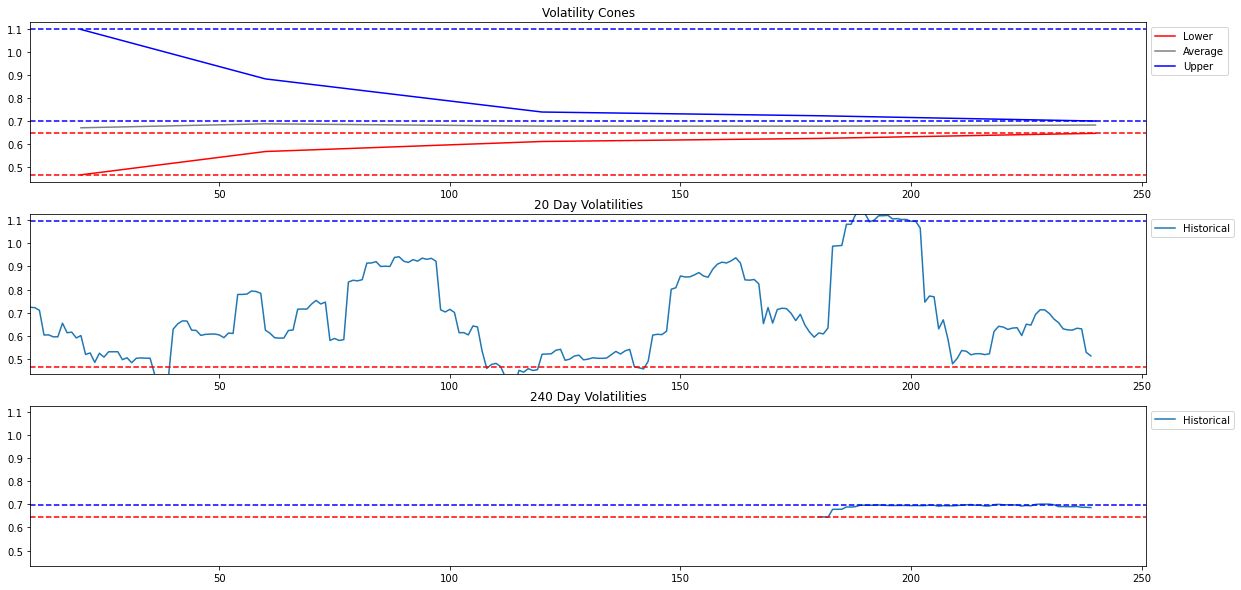

In [9]:
limit = max(days_to_expiry)
x = range(0, limit)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3, 1, 1)
plt.plot(days_to_expiry, lower, color='red', label='Lower')
plt.plot(days_to_expiry, means, color='grey', label='Average')
plt.plot(days_to_expiry, upper, color='blue', label='Upper')
plt.axhline(lower[0], linestyle='dashed', color='red')
plt.axhline(lower[-1], linestyle='dashed', color='red')
plt.axhline(upper[0], linestyle='dashed', color='blue')
plt.axhline(upper[-1], linestyle='dashed', color='blue')
ax1.set_title('Volatility Cones')
plt.legend(bbox_to_anchor=(1., 1.), loc=2)

ax2 = fig.add_subplot(3, 1, 2)
plt.plot(x, historical_sigma_20d[-limit:], label='Historical')
plt.axhline(lower[0], linestyle='dashed', color='red')
plt.axhline(upper[0], linestyle='dashed', color='blue')
ax2.set_title('20 Day Volatilities')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
plt.legend(bbox_to_anchor=(1., 1.), loc=2)

ax3 = fig.add_subplot(3, 1, 3)
plt.plot(x, historical_sigma_240d[-limit:], label='Historical')
plt.axhline(lower[-1], linestyle='dashed', color='red')
plt.axhline(upper[-1], linestyle='dashed', color='blue')
ax3.set_title('240 Day Volatilities')
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())
plt.legend(bbox_to_anchor=(1., 1.), loc=2)
plt.show()

In [10]:
start = datetime.datetime(2017,1,1)#获取数据的时间段-起始时间
end = datetime.date.today()#获取数据的时间段-结束时间
df = data.get_data_yahoo('BTC-USD', start=start, end=end)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-31,963.742981,947.236023,960.627014,963.742981,99135104,963.742981
2017-01-01,1003.080017,958.698975,963.658020,998.325012,147775008,998.325012
2017-01-02,1031.390015,996.702026,998.617004,1021.750000,222184992,1021.750000
2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,185168000,1043.839966
2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,344945984,1154.729980


In [11]:
df['log_ret'] = np.log(df['Close']/df['Close'].shift())
max = []
m75 = []
m50 = []
m25 = []

for i in np.arange(20,160,20):
    df[f'rv_{i}'] = df['log_ret'].rolling(i).std()*np.sqrt(365)
    max.append(df[f'rv_{i}'].quantile(1))
    m75.append(df[f'rv_{i}'].quantile(.75))
    m50.append(df[f'rv_{i}'].quantile(.5))
    m25.append(df[f'rv_{i}'].quantile(.25))


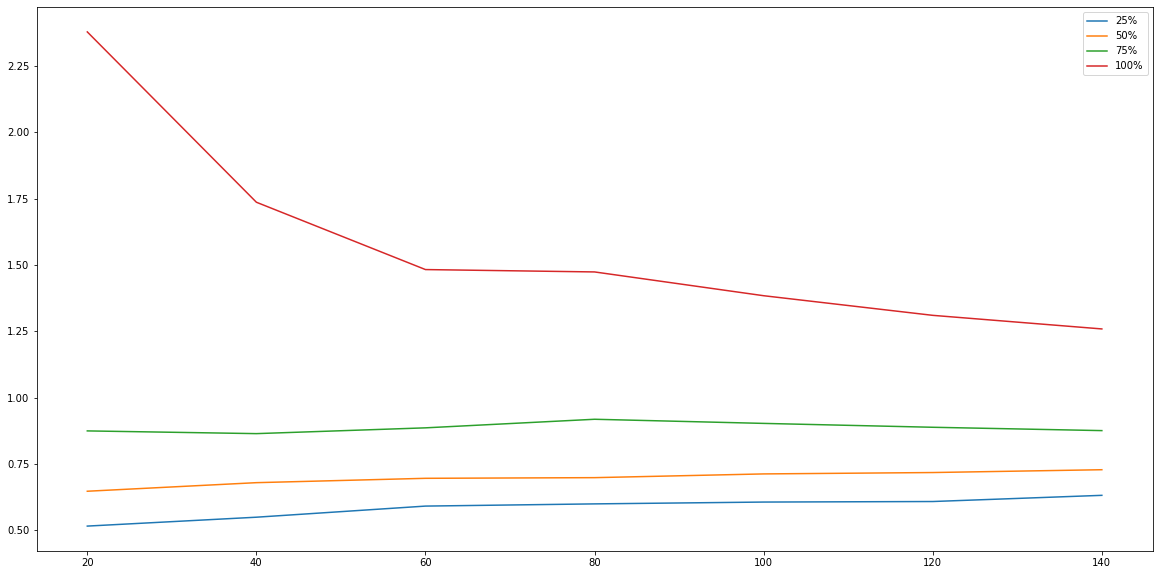

In [12]:
fig,ax = plt.subplots(figsize = (20,10))
x = np.arange(20,160,20)
ax.plot(x,m25,label='25%')
ax.plot(x,m50,label='50%')
ax.plot(x,m75,label='75%')
ax.plot(x,max,label='100%')
ax.legend()

plt.show()